In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir,'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

..\data


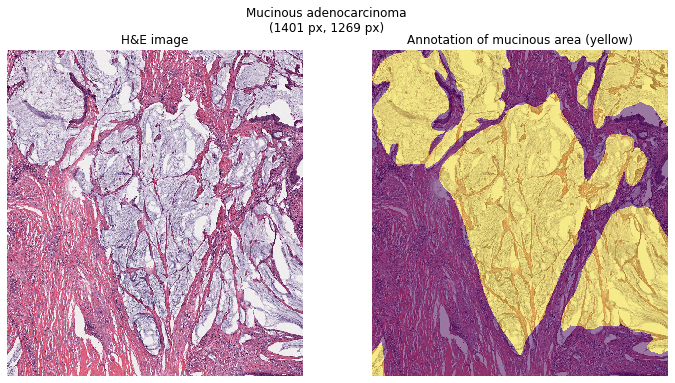

In [190]:
import skimage.io, skimage.color
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

<ipython-input-191-2ae7de7f92c2>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


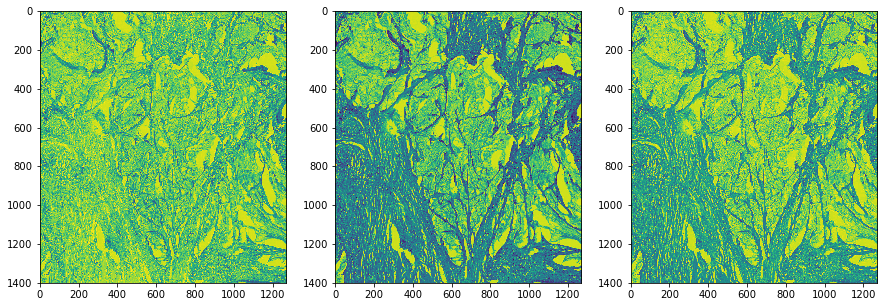

In [191]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].imshow(adeno_img[:,:,0], interpolation='nearest')
axs[1].imshow(adeno_img[:,:,1], interpolation='nearest')
axs[2].imshow(adeno_img[:,:,2], interpolation='nearest')
fig.show()

<ipython-input-246-0ae23a07f4e6>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


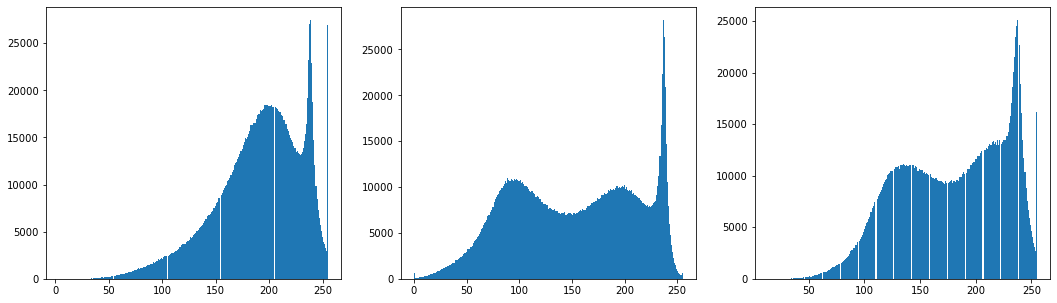

In [246]:
r = adeno_img[:,:,0].ravel()
g = adeno_img[:,:,1].ravel()
b = adeno_img[:,:,2].ravel()
gb = np.dstack((g,b))

n_bins = 256
fig, axs = plt.subplots(ncols=3, figsize=(18,5))
axs[0].hist(r,bins=n_bins)
axs[1].hist(g,bins=n_bins)
axs[2].hist(b,bins=n_bins)
fig.show()


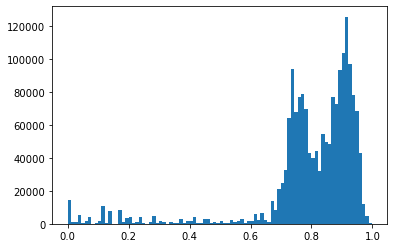

In [254]:
hue = skimage.color.rgb2hsv(adeno_img)[:,:,0].ravel()
plt.hist(hue, bins=90)
plt.show()

In [8]:
import sklearn
from sklearn.mixture import GaussianMixture
gm_red = GaussianMixture(n_components=2).fit(r.reshape(-1,1))
gm_green = GaussianMixture(n_components=2).fit(g.reshape(-1,1))
gm_blue = GaussianMixture(n_components=2).fit(b.reshape(-1,1))

#gm_clt.means_
r_binary = np.array([gm_red.means_[label] for label in gm_red.predict(r.reshape(-1,1))])
g_binary = np.array([gm_green.means_[label] for label in gm_green.predict(g.reshape(-1,1))])
b_binary = np.array([gm_blue.means_[label] for label in gm_blue.predict(b.reshape(-1,1))])

In [9]:
r_mean = np.ones(adeno_img.shape[:2])*np.mean(adeno_img[:,:,0].ravel())

In [10]:
#print(g.reshape(-1,1).reshape(1,-1))
#print(g_binary.reshape(1,-1)[0].reshape(im_h, im_w))
r_binary = r_binary.reshape(1,-1)[0].reshape(im_h, im_w)
g_binary = g_binary.reshape(1,-1)[0].reshape(im_h, im_w)
b_binary = b_binary.reshape(1,-1)[0].reshape(im_h, im_w)

(array([857384.,      0.,      0.,      0.,  26581.,  42726.,      0.,
             0.,      0., 851178.]),
 array([241.41921755, 259.47889117, 277.53856479, 295.59823841,
        313.65791203, 331.71758565, 349.77725927, 367.83693289,
        385.89660651, 403.95628014, 422.01595376]),
 <BarContainer object of 10 artists>)

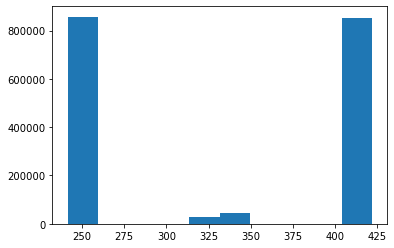

In [11]:
adeno_pred1 = np.array([r_mean,g_binary,b_binary],dtype=float)
rgb = np.dstack((r_mean,g_binary,b_binary)).astype(np.uint8)
#r.reshape(im_h,im_w).shape
lst = np.dstack((g_binary.ravel(),b_binary.ravel()))
lst = np.array([x[0]+x[1] for x in lst[0]])
np.unique(lst)
plt.hist(lst)

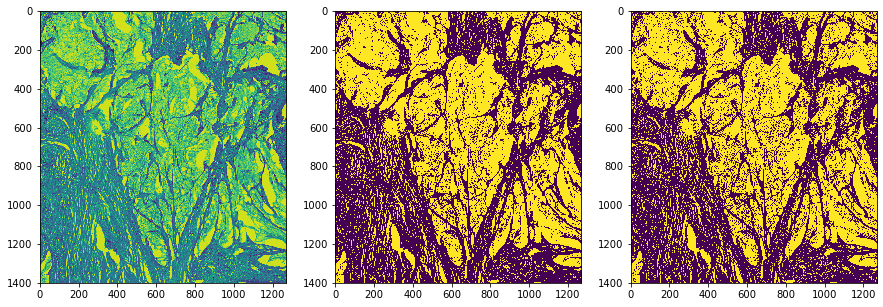

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].imshow(adeno_img[:,:,1], interpolation='nearest')
axs[1].imshow(g_binary, interpolation='nearest')
axs[2].imshow(b_binary, interpolation='nearest')



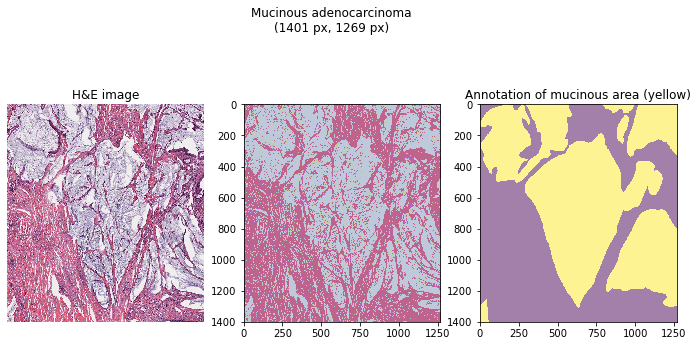

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(rgb, interpolation='nearest')
ax[2].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[2].set_title('Annotation of mucinous area (yellow)')
#ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
#ax[1].set_title('Annotation of mucinous area (yellow)')
#ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

In [14]:
g_01 = (g_binary > 150)
b_01 = (b_binary > 150)
g_error = 1 - np.sum((adeno_gt==g_01))/(adeno_gt.shape[0]*adeno_gt.shape[1])
b_error = 1 - np.sum((adeno_gt==b_01))/(adeno_gt.shape[0]*adeno_gt.shape[1])

print(" Green error",g_error,"\n", "Blue error", b_error)

 Green error 0.26459598541849816 
 Blue error 0.2784085891592688


Closing

C:\Users\Pranav\AppData\Local\Temp\ipykernel_14648\872211923.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


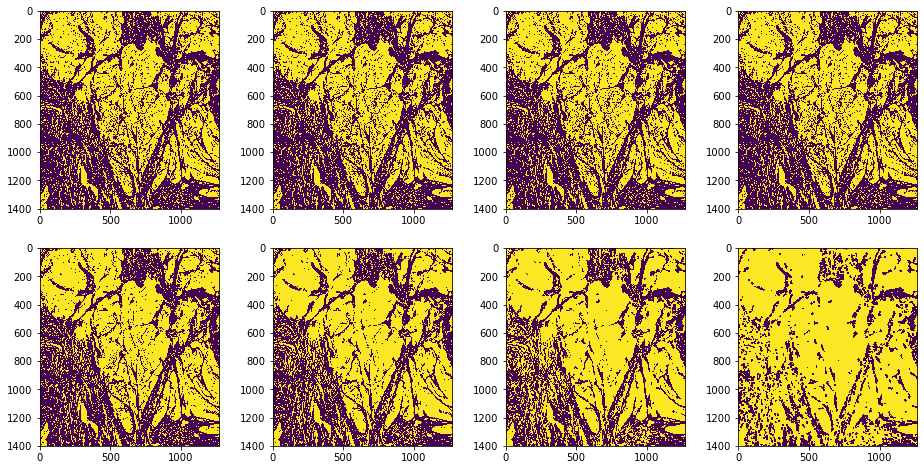

In [15]:
from skimage import morphology
fig, axs = plt.subplots(ncols=4,nrows=2,figsize = (16,8))

Radius = [1,2,3,5]
for i in range(4):
    closing = morphology.binary_closing(g_01,morphology.disk(radius=Radius[i]))
    axs[0][i].imshow(g_01, interpolation='nearest')
    axs[1][i].imshow(closing, interpolation='nearest')
fig.show()
#fig.tight_layout()

Opening

C:\Users\Pranav\AppData\Local\Temp\ipykernel_14648\2912539640.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


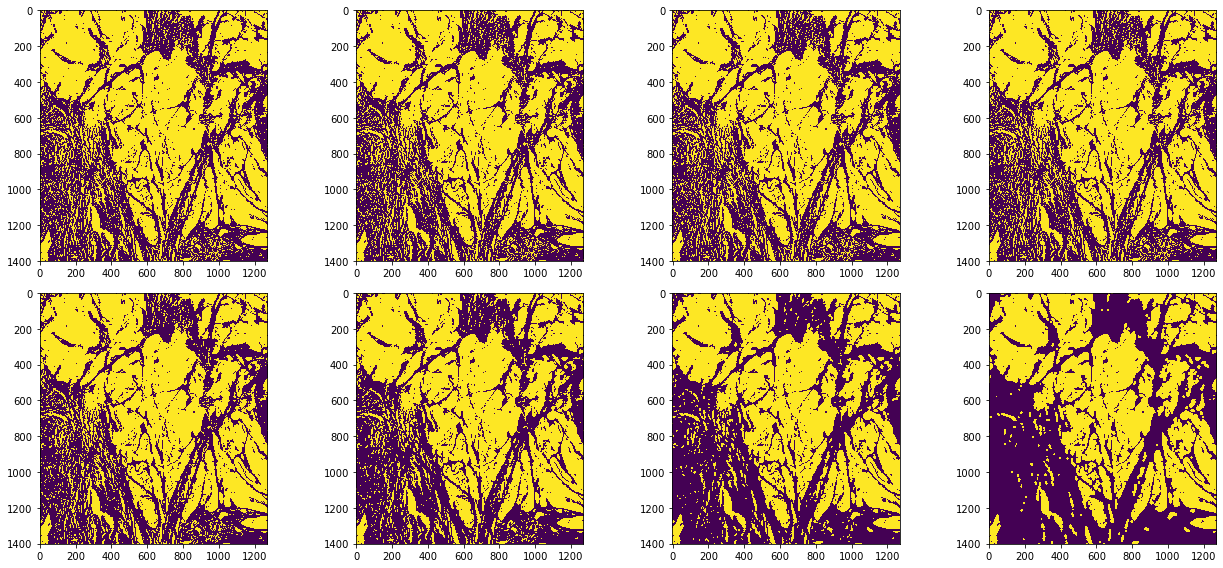

In [16]:
fig, axs = plt.subplots(ncols=4,nrows=2,figsize = (18,8))

closing = morphology.binary_closing(g_01, morphology.disk(radius=2))
Radius = [1,2,3,5]
for i in range(4):
    opening = morphology.binary_opening(closing,morphology.disk(radius=Radius[i]))
    axs[0][i].imshow(closing, interpolation='nearest')
    axs[1][i].imshow(opening, interpolation='nearest')
fig.show()
fig.tight_layout()

Remove small holes

C:\Users\Pranav\AppData\Local\Temp\ipykernel_14648\4057232248.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


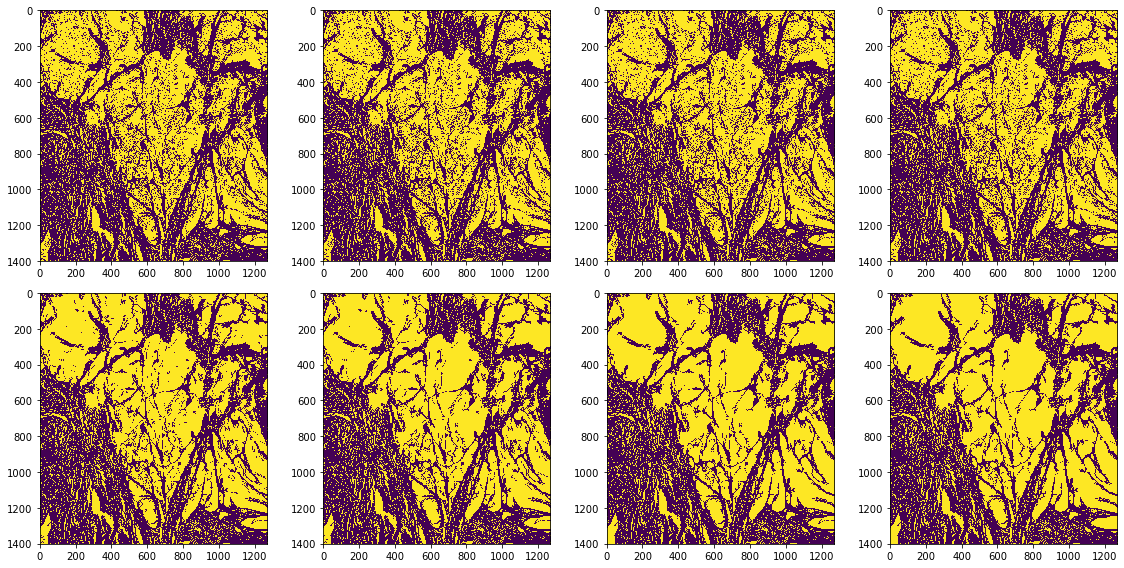

In [17]:
from skimage import morphology
fig, axs = plt.subplots(ncols=4,nrows=2,figsize = (16,8))

#opening = morphology.binary_opening(closing,morphology.disk(radius=5))
thresh = [50,100,500,1000]
for i in range(4):
    no_holes = morphology.remove_small_holes(b_01,area_threshold=thresh[i])
    axs[0][i].imshow(b_01, interpolation='nearest')
    axs[1][i].imshow(no_holes, interpolation='nearest')
    print()
fig.show()
fig.tight_layout()

C:\Users\Pranav\AppData\Local\Temp\ipykernel_14648\3489441338.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


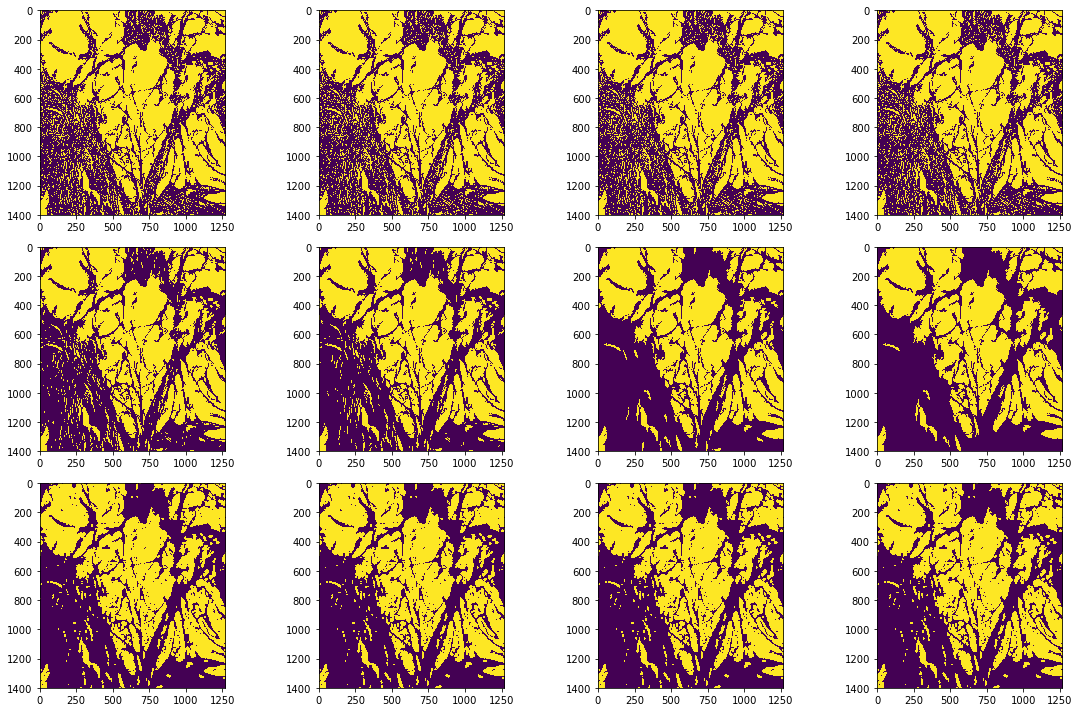

In [18]:
fig, axs = plt.subplots(ncols=4,nrows=3,figsize = (16,10))

no_holes = morphology.remove_small_holes(b_01,area_threshold=1000)
size = [50,100,500,1000]
for i in range(4):
    no_objects = morphology.remove_small_objects(no_holes,min_size = size[i])
    axs[0][i].imshow(no_holes, interpolation='nearest')
    axs[1][i].imshow(no_objects, interpolation='nearest')
    axs[2][i].imshow(opening, interpolation='nearest')
fig.show()
fig.tight_layout()

Combining multiple methods

closing 1 0.15075351446028928
closing 2 0.1446287662364325 

closing 1 0.1453312926880439
closing 2 0.13942984550605242 

closing 1 0.13537049130166512
closing 2 0.13082178720704396 

closing 1 0.12203992532633168
closing 2 0.12045488165888485 



C:\Users\Pranav\AppData\Local\Temp\ipykernel_14648\2572192521.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


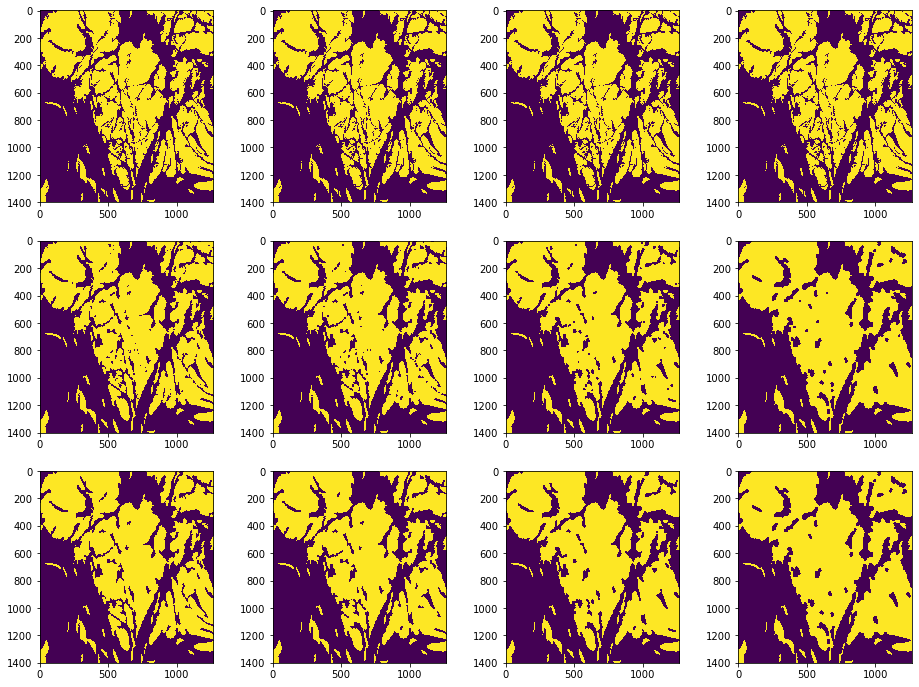

In [19]:
fig, axs = plt.subplots(ncols=4,nrows=3,figsize = (16,12))

no_objects = morphology.remove_small_objects(no_holes,min_size = 500)
Radius = [4,5,7,10]
for i in range(4):
    closing_1 = morphology.binary_closing(no_objects,morphology.disk(radius=Radius[i]))
    closing_2 = morphology.remove_small_holes(closing_1,500)
    axs[0][i].imshow(no_objects, interpolation='nearest')
    axs[1][i].imshow(closing_1, interpolation='nearest')
    axs[2][i].imshow(closing_2, interpolation='nearest')
    print('closing 1',1 - np.mean((adeno_gt==closing_1)))
    print('closing 2',1 - np.mean((adeno_gt==closing_2)),'\n')
fig.show()
#fig.tight_layout()

error 0.13282362198789677


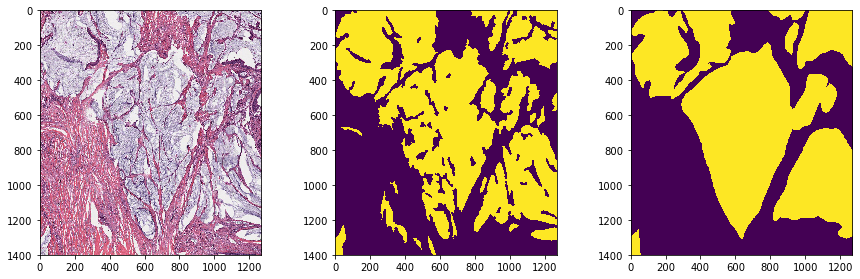

In [20]:
no_holes = morphology.remove_small_holes(b_01,area_threshold=1000)
no_objects = morphology.remove_small_objects(no_holes,min_size = 1000)
closing_1 = morphology.binary_closing(no_objects,morphology.disk(radius=5))
no_holes_2 = morphology.remove_small_holes(closing_1,500)
mask = no_holes_2
fig, axs = plt.subplots(ncols=3, figsize = (15,4.5))
axs[0].imshow(adeno_img, interpolation='nearest')
axs[1].imshow(mask, interpolation='nearest')
axs[2].imshow(adeno_gt, interpolation='nearest')
print('error',1 - np.mean((adeno_gt==mask)))

## Region growing

In [187]:
import cv2

def grow(image, i, j, labels):
    I,J = image.shape
    #print(i,j,"label",labels[i][j])
    if labels[i][j] == 'na':
        labels[i][j] = 1
        for x,y in [(i+1,j),(i,j+1),(i-1,j),(i,j-1)]:
            if 0<=x<I and 0<=y<J and image[x][y]==image[i][j]:
                grow(image,x,y,labels)
    
def get8n(x, y, shape):
    out = []
    maxx = shape[0]-1
    maxy = shape[1]-1
    
    #top left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #top center
    outx = x
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #top right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #left
    outx = min(max(x-1,0),maxx)
    outy = y
    out.append((outx,outy))
    
    #right
    outx = min(max(x+1,0),maxx)
    outy = y
    out.append((outx,outy))
    
    #bottom left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    #bottom center
    outx = x
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    #bottom right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    return out
    
def region_growing(img, seed, processed):
    seed_points = []
    outimg = np.zeros_like(img)
    seed_points.append((seed[0], seed[1]))
    while(len(seed_points) > 0):
        pix = seed_points[0]
        outimg[pix[0], pix[1]] = 255
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                outimg[coord[0], coord[1]] = 255
                if processed[coord[0]][coord[1]]==False:
                    seed_points.append(coord)
                processed[coord[0]][coord[1]] = True
        seed_points.pop(0)
        #plt.imshow(outimg)
        #cv2.waitKey(1)
    return outimg

def region_labelling(img, seed, labels,value):
    seed_points = []
    seed_points.append((seed[0], seed[1]))
    while(len(seed_points) > 0):
        pix = seed_points[0]
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                if labels[coord[0]][coord[1]]==0:
                    seed_points.append(coord)
                labels[coord[0]][coord[1]] = value
        seed_points.pop(0)

def extract_objects(image):
    labels = np.zeros_like(image)
    I, J = image.shape
    max_label = 0
    for i in range(I):
        for j in range(J):
            if image[i][j]>0 and labels[i][j]==0:
                region_labelling(img=image,seed=[i,j],labels=labels,value=max_label+1)
                max_label+=1
    return labels

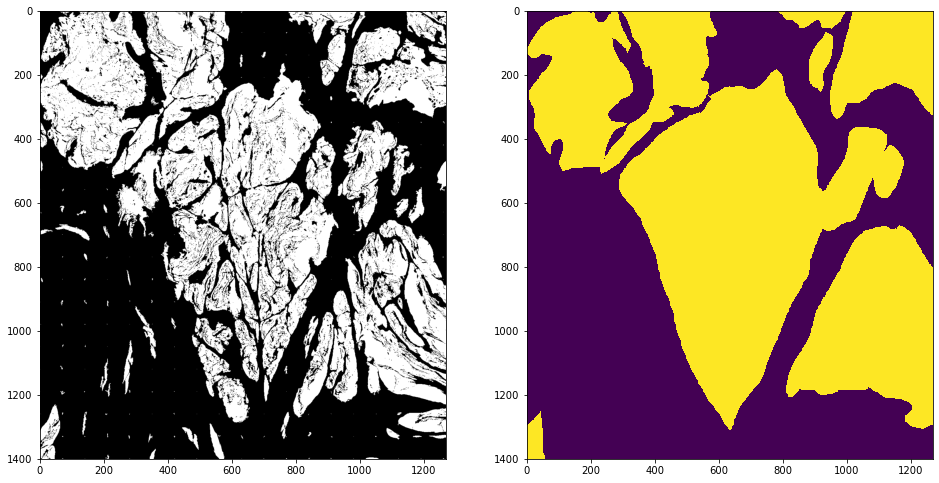

In [244]:
from scipy.stats import uniform
np.random.seed(0)

def region_growing_hard(img, seed, processed,p,thresh):
    seed_points = []
    outimg = np.zeros_like(img)
    seed_points.append((seed[0], seed[1]))
    while(len(seed_points) > 0):
        pix = seed_points[0]
        outimg[pix[0], pix[1]] = 255
        temp_sum = 0
        length = 0
        for coord in get8n(pix[0], pix[1], img.shape):
            temp_sum = img[coord[0], coord[1]] + temp_sum
            length = length + 1
        for coord in get8n(pix[0], pix[1], img.shape):      
            if img[coord[0], coord[1]] >150 or abs(img[coord[0], coord[1]] - temp_sum/length) < thresh:
                outimg[coord[0], coord[1]] = 255
                if processed[coord[0]][coord[1]]==False:
                    if uniform.rvs(0,1)>p:
                        seed_points.append(coord)   
                processed[coord[0]][coord[1]] = True
        seed_points.pop(0)
    return outimg


vect_max = np.vectorize(max)

def extract_objects_harder(img,step,p,thresh):
    processed = np.zeros_like(img)
    labels = np.zeros_like(img)
    I, J = img.shape
    max_label = 0
    outimg = np.zeros_like(img)
    i=0
    j=0
    while i<I:
        j=0
        while j<J:
            outimg = outimg + region_growing_hard(img,[i,j],processed,p,thresh)
            j+=step
        i+=step
    return (outimg>0)

output = extract_objects_harder(adeno_img[:,:,1],step=70,p = 0.3,thresh=3.5)

fig, axs = plt.subplots(ncols=2,nrows=1,figsize = (16,10))

axs[0].imshow(output, cmap = 'gray')
axs[1].imshow(adeno_gt, interpolation='nearest')
plt.show()

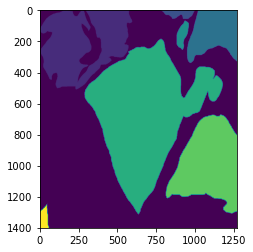

In [43]:
vect_int = np.vectorize(int)

outimg = extract_objects(vect_int(adeno_gt))
plt.imshow(outimg)

..\data


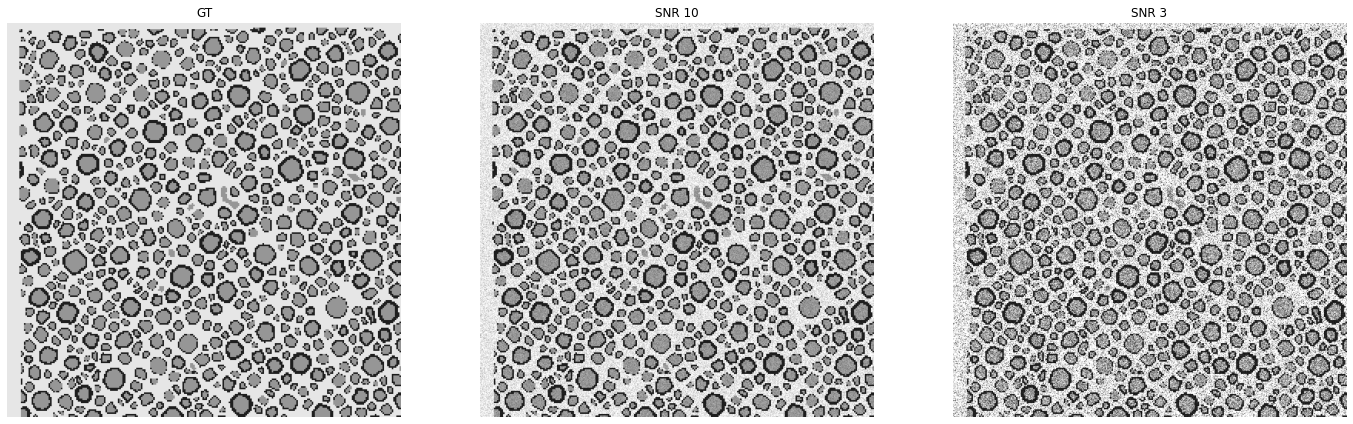

In [6]:
import cv2

data_base_path = os.path.join(os.pardir,'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

## work with SNR images

In [273]:
import numpy as np
from scipy.signal import wiener
import matplotlib.pyplot as plt




from skimage import color, data, restoration
from skimage.filters import wiener
rng = np.random.default_rng()

from scipy.signal import convolve2d as conv2
psf = np.ones((4,4)) / 16
#got ground truth
astro_gt = conv2(color.rgb2gray(gt_0), psf, 'same')

deconvolved_gt, _ = restoration.unsupervised_wiener(astro_gt, psf)
#for snr 10
astro_10 = conv2(color.rgb2gray(snr_10), psf, 'same')




def fun(x):
    return 0.1

#deconvolved_10, _ = skimage.filters.wiener(data = astro_10, K = 0.1)
deconvolved_10 = wiener(astro_10,(5,5))  







#for snr 3
astro_3 = conv2(color.rgb2gray(snr_3), psf, 'same')

#deconvolved_3, _ = skimage.filters.wiener(data = astro_3, K = 0.333)
deconvolved_3 = wiener(astro_3, mysize = (5, 5), noise = 0.33)  





#ploting
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(48, 35),
                       sharex=True, sharey=True)

plt.gray()

ax[0,0].imshow(astro_gt, vmin=deconvolved_gt.min(), vmax=deconvolved_gt.max())
ax[0,0].axis('off')
ax[0,0].set_title('Data gt')

ax[0,1].imshow(deconvolved_gt)
ax[0,1].axis('off')
ax[0,1].set_title('Self tuned restoration for gt')

ax[1,0].imshow(snr_10, vmin=deconvolved_10.min(), vmax=deconvolved_10.max())
ax[1,0].axis('off')
ax[1,0].set_title('Data snr 10')

ax[1,1].imshow(deconvolved_10)
ax[1,1].axis('off')
ax[1,1].set_title('Self tuned restoration for snr 10')

ax[2,0].imshow(snr_3, vmin=deconvolved_3.min(), vmax=deconvolved_3.max())
ax[2,0].axis('off')
ax[2,0].set_title('Data snr 3')

ax[2,1].imshow(deconvolved_3)
ax[2,1].axis('off')
ax[2,1].set_title('Self tuned restoration for snr 3')

fig.tight_layout()

plt.show()

ValueError: Impulse response must be a callable.

<ipython-input-257-26ced234db4c>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


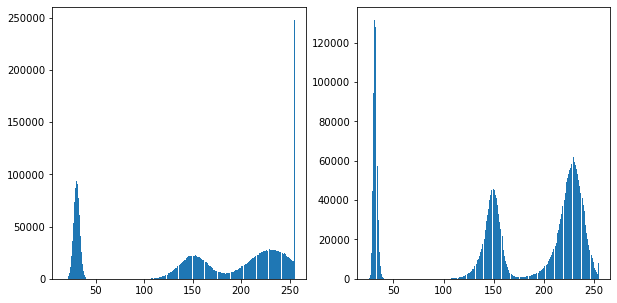

In [257]:
n_bins = 256
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].hist(snr_10.ravel(),bins=n_bins)
axs[1].hist(medianed_snr10.ravel(),bins=n_bins)
fig.show()

## work with GT images

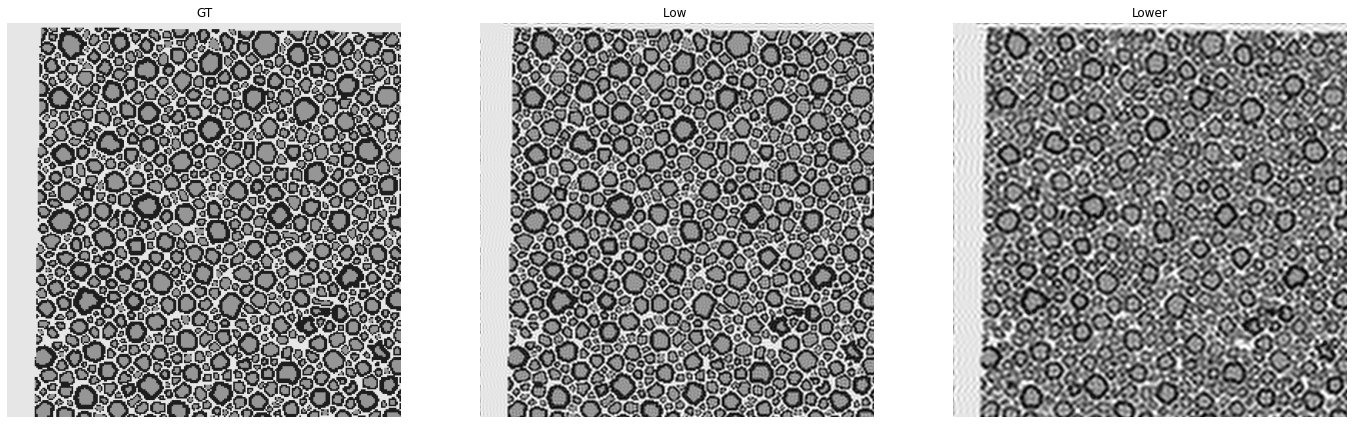

In [7]:
files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [9]:
def idk(x,colors):
    if x[0]==colors[0]:
        return np.array([255,0,0])
    if x[0]==colors[1]:
        return np.array([0,0,255])
    if x[0]==colors[2]:
        return np.array([255,255,255])
    
def paint(image):
    output = np.zeros_like(image)
    colors = np.unique(image.ravel())
    I, J = image.shape[:2]
    for i in range(I):
        for j in range(J):
            output[i][j] = idk(image[i][j],colors)
    return output
    

In [155]:
gt_3[]

(1024, 1024, 3)

<ipython-input-172-6bde44a8c4ed>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


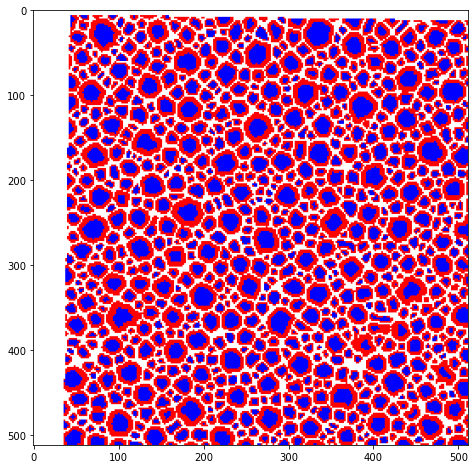

In [172]:
gt_3_painted = paint(gt_3)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(gt_3_painted[:512,:512])
fig.show()

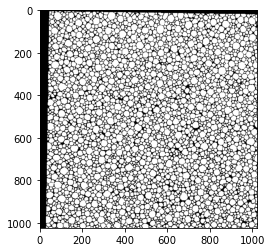

780.0


In [173]:
gt_3_gray = 1 - gt_3_painted[:,:,1]/255.0
plt.imshow(gt_3_gray,cmap='gray')
plt.show()
labelled_balls = extract_objects(gt_3_gray)
print(np.max(labelled_balls))

In [174]:
distinct_labels = range(1,int(np.max(labelled_balls)))
inner_balls = labelled_balls*(gt_3_painted[:,:,2]/255.0)
outer_areas = np.array([])
inner_areas = np.array([])
for i in distinct_labels:
    outer_areas = np.append(outer_areas,np.sum(labelled_balls==i))
    inner_areas = np.append(inner_areas,np.sum(inner_balls==i))

<ipython-input-175-c2375243d0ed>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


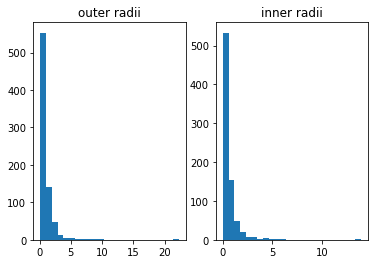

In [175]:
outer_radii = np.sqrt(outer_areas/np.pi) * 0.1
inner_radii = np.sqrt(inner_areas/np.pi) * 0.1
fig, ax = plt.subplots(ncols=2)
ax[0].hist(outer_radii,bins=24)
ax[1].hist(inner_radii,bins=24)
ax[0].set_title("outer radii")
ax[1].set_title("inner radii")
fig.show()

In [14]:
def ball_labeling(img, seed, labels,value):
    seed_points = []
    seed_points.append((seed[0], seed[1]))
    while(len(seed_points) > 0):
        pix = seed_points[0]
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                if labels[coord[0]][coord[1]]==[]:
                    seed_points.append(coord)
                labels[coord[0]][coord[1]] = value
        seed_points.pop(0)

def balls(image):
    labels = np.zeros_like(image)
    I, J = image.shape
    max_label = 0
    for i in range(I):
        for j in range(J):
            if image[i][j]>0 and labels[i][j]==0:
                region_labelling(img=image,seed=[i,j],labels=labels,value=max_label+1)
                max_label+=1
    return labels

In [181]:
def radii(img):
    img_gray = 1 - img[:,:,1]/255.0
    labelled_balls = extract_objects(img_gray)
    distinct_labels = range(1,int(np.max(labelled_balls)))
    inner_balls = labelled_balls*(img[:,:,2]/255.0)
    outer_areas = np.array([])
    inner_areas = np.array([])
    for i in distinct_labels:
        outer_areas = np.append(outer_areas,np.sum(labelled_balls==i))
        inner_areas = np.append(inner_areas,np.sum(inner_balls==i))
    outer_radii = np.sqrt(outer_areas/np.pi) * 0.1
    inner_radii = np.sqrt(inner_areas/np.pi) * 0.1
    return inner_radii, outer_radii

<ipython-input-183-6dcf2ae364e9>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


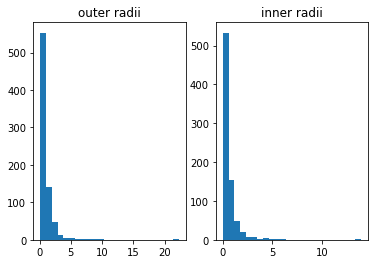

In [183]:
inner_gt, outer_gt = radii(gt_3_painted)
fig, ax = plt.subplots(ncols=2)
ax[0].hist(outer_gt,bins=24)
ax[1].hist(inner_gt,bins=24)
ax[0].set_title("outer radii")
ax[1].set_title("inner radii")
fig.show()

## Work with low frequencies

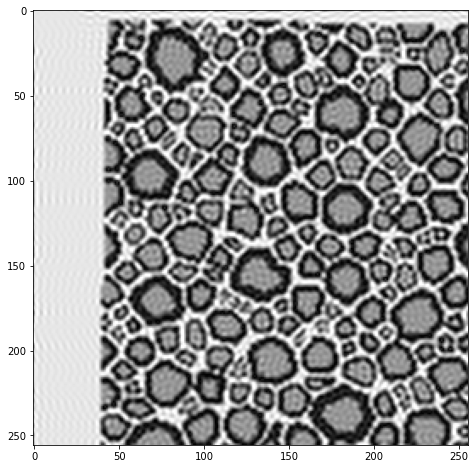

In [16]:
#lowfreq0.shape
plt.figure(figsize=(8,8))
plt.imshow(lowfreq0[:256,:256,0],cmap='gray')
lowfreq0_r = lowfreq0[:,:,0]

In [21]:
from skimage import filters
from scipy import ndimage
from skimage import restoration

sharpen_filter_0=np.array([[-1,-1,-1],
                 [-1,9,-1],
                [-1,-1,-1]])
sharpen_filter_1=np.array([[1,-2,1],
                 [-2,5,-2],
                [1,-2,1]])
# applying kernels to the input image to get the sharpened image
#img_0 = lowfreq0_r[:100,:100]
sharp_image0=cv2.filter2D(lowfreq0,-1,sharpen_filter_0)
sharp_image1=cv2.filter2D(lowfreq0,-1,sharpen_filter_1)

median_filtered0 = filters.median(lowfreq0)
deconvolved_img = restoration.unsupervised_wiener(rgb2gray(median_filtered0), psf)
#cv2.imshow('Required image',sharp_image0)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow()

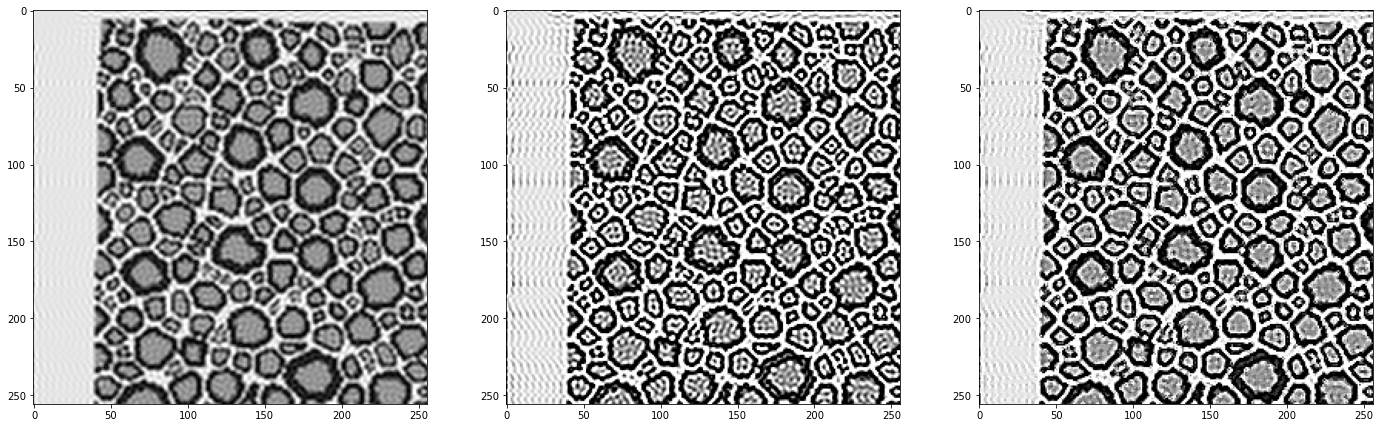

In [54]:
fig, axs = plt.subplots(ncols=3,figsize=(24,8))
axs[0].imshow(lowfreq0[0:256,0:256])
axs[1].imshow(sharp_image0[0:256,0:256])
axs[2].imshow(cv2.filter2D(median_filtered0,-1,sharpen_filter_0)[0:256,0:256,2],cmap='gray')

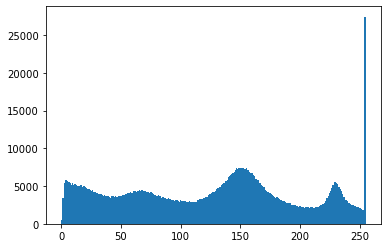

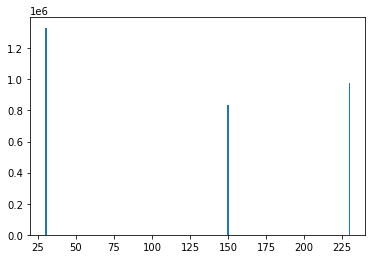

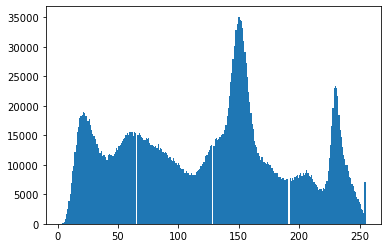

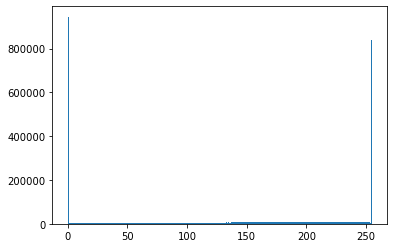

In [40]:
plt.hist(lowfreq0_r.ravel(),bins=256)
plt.show()
plt.figure()
plt.hist(gt_3.ravel(),bins=256)
plt.show()
plt.figure()
plt.hist(median_filtered0.ravel(),bins=256)
plt.show()
plt.hist(cv2.filter2D(median_filtered0,-1,sharpen_filter_0).ravel(),bins=256)
plt.show()

<ipython-input-97-a6ada1ab13b4>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


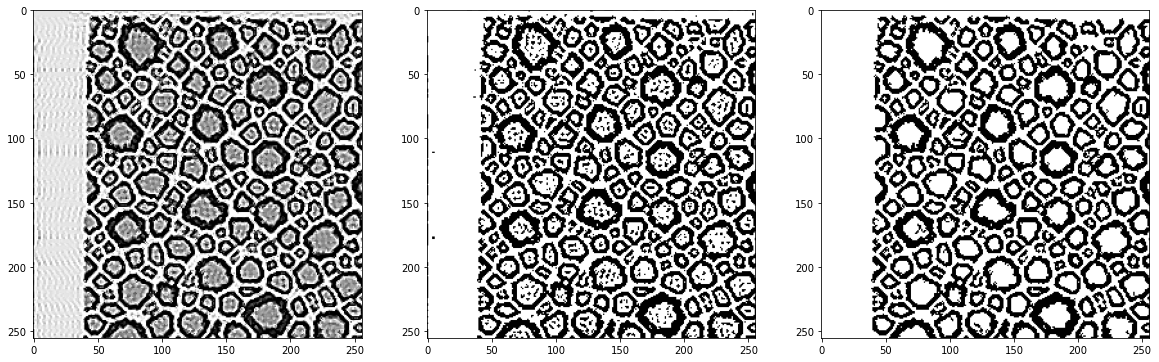

In [97]:
from skimage import morphology
img_0 = cv2.filter2D(median_filtered0,-1,sharpen_filter_0)
thresh = 125
new_img_0 = (img_0>thresh)[:,:,2]
fig, axs = plt.subplots(ncols=3,figsize=(20,7))
axs[0].imshow(img_0[:256,:256])
axs[1].imshow(new_img_0[:256,:256],cmap='gray')
no_holes_0 = morphology.remove_small_holes(new_img_0,area_threshold=30,connectivity=2)
axs[2].imshow(no_holes_0[:256,:256],cmap='gray')
fig.show()

<ipython-input-115-e1b1263361cb>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


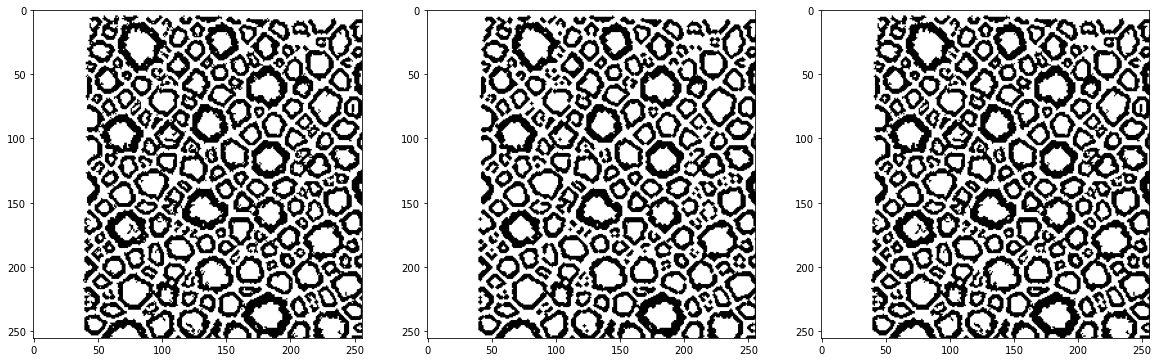

In [115]:
fig, axs = plt.subplots(ncols=3,figsize=(20,7))
axs[1].imshow(morphology.binary_closing(no_holes_0, morphology.disk(radius=1))[:256,:256],cmap='gray')
axs[0].imshow(no_holes_0[:256,:256],cmap='gray')
no_holes_no_objects_0 = morphology.remove_small_objects(no_holes_0, 4)
axs[2].imshow(no_holes_no_objects_0[:256,:256],cmap='gray')
fig.show()

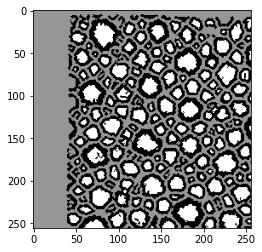

In [136]:
bg = region_growing(no_holes_no_objects_0,
                           seed=[1,1],
                           processed=np.zeros_like(no_holes_no_objects_0))
new_img_1 = vect_int(no_holes_no_objects_0)*255.0
new_img_1[bg==True] = 150
plt.imshow(new_img_1[:256,:256],cmap='gray')
plt.show()

(1024, 1024)


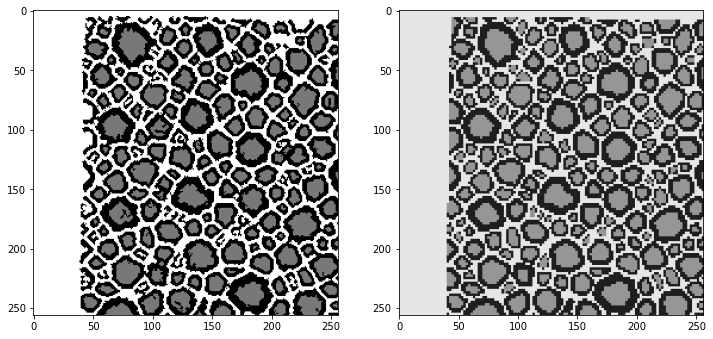

In [145]:
new_img_2 = np.copy(new_img_1)
new_img_2[new_img_2==255.0] = 120
new_img_2[new_img_2==150] = 255
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
axs[0].imshow(new_img_2[:256,:256],cmap='gray')
axs[1].imshow(gt_3[:256,:256],cmap='gray')
np.unique(new_img_1)
print(new_img_2.shape)

In [156]:
new_img_2

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [120., 120., 120.],
        [120., 120., 120.],
        [120., 120., 120.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [  0.,   0.,   0.],
        [120., 120., 120.],
        [120., 120., 120.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [153]:
new_img_2.shape

(1024, 1024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-185-e48c9428d411>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


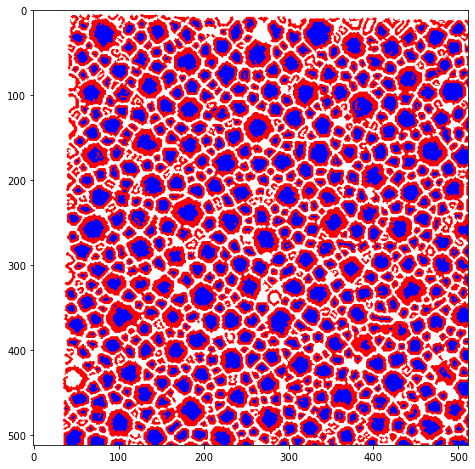

In [185]:
median_filtered0 = filters.median(lowfreq0)
img_0 = cv2.filter2D(median_filtered0,-1,sharpen_filter_0)

thresh = 100
new_img_0 = (img_0>thresh)[:,:,2]
no_holes_0 = morphology.remove_small_holes(new_img_0,area_threshold=20,connectivity=2)
bg = region_growing(no_holes_no_objects_0,
                           seed=[1,1],
                           processed=np.zeros_like(no_holes_no_objects_0))
new_img_1 = vect_int(no_holes_no_objects_0)*255.0
new_img_1[bg==True] = 150
new_img_2 = np.copy(new_img_1)
new_img_2[new_img_2==255.0] = 120
new_img_2[new_img_2==150] = 255
new_img_2 = np.dstack([new_img_2,new_img_2,new_img_2])
new_image_painted = paint(new_img_2)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(new_image_painted[:512,:512])
fig.show()

<ipython-input-186-04363c710499>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


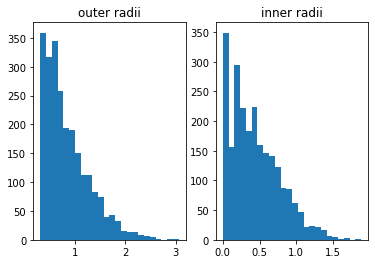

In [186]:
inner, outer = radii(new_image_painted)
fig, ax = plt.subplots(ncols=2)
ax[0].hist(outer,bins=24)
ax[1].hist(inner,bins=24)
ax[0].set_title("outer radii")
ax[1].set_title("inner radii")
fig.show()

<ipython-input-169-07c97ab43a31>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


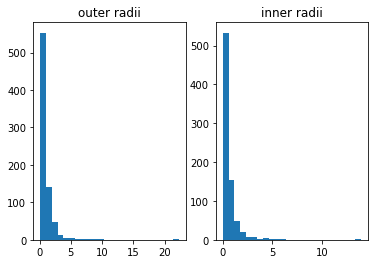

In [169]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(outer_radii,bins=24)
ax[1].hist(inner_radii,bins=24)
ax[0].set_title("outer radii")
ax[1].set_title("inner radii")
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-157-85f407e6950d>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


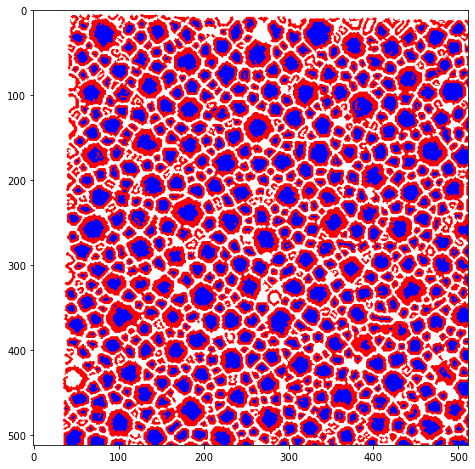